In [ ]:
import os
import numpy as np
import torch
from PIL import Image

import torchvision.transforms as T


class ClothingDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned.
        self.imgs = list(sorted(os.listdir(os.path.join(root, "png_images/IMAGES"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "png_masks/MASKS"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "png_images/IMAGES", self.imgs[idx])
        mask_path = os.path.join(self.root, "png_masks/MASKS",self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # grey-scale

        # transform = T.RandomHorizontalFlip(p=0.5)
        randomize=1 if torch.rand(1)>=0.5 else 0
        if randomize==1:
          transform = T.RandomHorizontalFlip(p=randomize)
          img=transform(img)
          mask=transform(mask)
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        if len(obj_ids)==1:
            return
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of binary masks.
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        def extract_masks(holistic_mask):
            unique_pixels = np.unique(holistic_mask)
            masker = []
            for pixel_value in unique_pixels:
                binary_mask = (holistic_mask == pixel_value).astype(np.uint8)
                masker.append(binary_mask)
            return masker
        masks = extract_masks(mask)
        # if len(boxes)==0:
        #   boxes.append([1,1,1,1])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        # labels = torch.ones((num_objs,), dtype=torch.int64)
        # labels = torch.zeros((58,), dtype=torch.int64)
        labels=[]
        for i in obj_ids:
          # print(i)
          labels.append(i)
        labels=torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id


        if self.transforms is not None:
          img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')  # Change directory to the root of your Google Drive
os.listdir('.')  # Lists the files in the current directory

['AML_Project.ipynb',
 'jpeg_images',
 'png_images',
 'labels (1).csv',
 'labels.csv',
 'png_masks']

In [ ]:
import torchvision.transforms as T

img = Image.open("/content/drive/My Drive/Colab Notebooks/png_masks/MASKS/seg_0001.png").convert("L")
img_tensor = T.PILToTensor()(img)
img_tensor.shape
# img_tensor.unique()
# m=get_transform(True)
# print(typer)

torch.Size([1, 825, 550])

In [ ]:
#-----------------IGNORE---------------------------------------------

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 58  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(model)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 128
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    # print(model)

    return model

In [ ]:
model = get_model_instance_segmentation(num_classes=58)
# model=torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
# model=torchvision.models.detection.rpn
print(model)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 78.2MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
import torchvision.transforms as T

def get_transform():
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    # if train:
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    # transforms.append(T.Resize((height, width)))
    return T.Compose(transforms)

In [ ]:
import torch
import torchvision
from torchvision import transforms, utils
# def collate_fn(batch):
#     return tuple(zip(*batch))
def collate_fn(batch):
    batch = [data for data in batch if data is not None]
    # Your remaining collate logic here
    return tuple(zip(*batch))

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = ClothingDataset('/content/drive/My Drive/Colab Notebooks', transforms=get_transform())
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True,collate_fn=collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

<ipython-input-1-5f2adf3f8461>:72: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 59
dataset = ClothingDataset('/content/drive/MyDrive/Clothing DataSet', get_transform())
dataset_test = ClothingDataset('/content/drive/MyDrive/Clothing DataSet', get_transform())

# split the dataset into train and test sets
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
print(len(dataset))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2,collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2,collate_fn=collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# # and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# optimizer=torch.optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.9), eps=1)# and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# let's train it for 10 epochs
num_epochs = 3

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  # evaluate(model, data_loader_test, device=device)


950
Epoch: [0]  [  0/475]  eta: 0:28:51  lr: 0.005000  loss: 6.3613 (6.3613)  loss_classifier: 4.0405 (4.0405)  loss_box_reg: 0.5110 (0.5110)  loss_mask: 0.8296 (0.8296)  loss_objectness: 0.9108 (0.9108)  loss_rpn_box_reg: 0.0695 (0.0695)  time: 3.6448  data: 2.9227  max mem: 8852
Epoch: [0]  [ 10/475]  eta: 0:15:09  lr: 0.005000  loss: 2.6842 (3.2788)  loss_classifier: 1.2103 (1.7371)  loss_box_reg: 0.5884 (0.6169)  loss_mask: 0.6827 (0.6890)  loss_objectness: 0.0947 (0.1857)  loss_rpn_box_reg: 0.0492 (0.0501)  time: 1.9555  data: 1.2817  max mem: 8870
Epoch: [0]  [ 20/475]  eta: 0:13:21  lr: 0.005000  loss: 2.3440 (2.8194)  loss_classifier: 0.9907 (1.3785)  loss_box_reg: 0.6264 (0.6500)  loss_mask: 0.5806 (0.6105)  loss_objectness: 0.0552 (0.1322)  loss_rpn_box_reg: 0.0443 (0.0482)  time: 1.6671  data: 0.9958  max mem: 8870
Epoch: [0]  [ 30/475]  eta: 0:12:19  lr: 0.005000  loss: 2.2273 (2.6117)  loss_classifier: 0.9725 (1.2466)  loss_box_reg: 0.6836 (0.6739)  loss_mask: 0.4527 (0.54

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10e56ec670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10e56ec670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: [0]  [230/475]  eta: 0:06:20  lr: 0.005000  loss: 1.2705 (1.6770)  loss_classifier: 0.5077 (0.7268)  loss_box_reg: 0.4908 (0.5867)  loss_mask: 0.1978 (0.2857)  loss_objectness: 0.0293 (0.0419)  loss_rpn_box_reg: 0.0284 (0.0359)  time: 1.4960  data: 0.8164  max mem: 8871


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10e56ec670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10e56ec670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: [0]  [240/475]  eta: 0:06:05  lr: 0.005000  loss: 1.3456 (1.6633)  loss_classifier: 0.5385 (0.7212)  loss_box_reg: 0.5053 (0.5833)  loss_mask: 0.1887 (0.2815)  loss_objectness: 0.0201 (0.0415)  loss_rpn_box_reg: 0.0285 (0.0358)  time: 1.5581  data: 0.8788  max mem: 8871
Epoch: [0]  [250/475]  eta: 0:05:48  lr: 0.005000  loss: 1.2940 (1.6468)  loss_classifier: 0.5688 (0.7147)  loss_box_reg: 0.5062 (0.5783)  loss_mask: 0.1644 (0.2772)  loss_objectness: 0.0207 (0.0409)  loss_rpn_box_reg: 0.0301 (0.0357)  time: 1.4975  data: 0.8172  max mem: 8871
Epoch: [0]  [260/475]  eta: 0:05:35  lr: 0.005000  loss: 1.1889 (1.6310)  loss_classifier: 0.5130 (0.7086)  loss_box_reg: 0.4506 (0.5733)  loss_mask: 0.1729 (0.2737)  loss_objectness: 0.0212 (0.0402)  loss_rpn_box_reg: 0.0280 (0.0353)  time: 1.6507  data: 0.9455  max mem: 8871
Epoch: [0]  [270/475]  eta: 0:05:19  lr: 0.005000  loss: 1.1677 (1.6200)  loss_classifier: 0.5044 (0.7029)  loss_box_reg: 0.4363 (0.5703)  loss_mask: 0.1855 (0.2720) 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10e56ec670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10e56ec670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: [1]  [ 80/475]  eta: 0:10:24  lr: 0.005000  loss: 1.0742 (1.0987)  loss_classifier: 0.4523 (0.4429)  loss_box_reg: 0.4166 (0.4027)  loss_mask: 0.1817 (0.1755)  loss_objectness: 0.0185 (0.0292)  loss_rpn_box_reg: 0.0261 (0.0484)  time: 1.5494  data: 0.8653  max mem: 8874
Epoch: [1]  [ 90/475]  eta: 0:09:59  lr: 0.005000  loss: 1.0713 (1.0910)  loss_classifier: 0.4373 (0.4394)  loss_box_reg: 0.3966 (0.3997)  loss_mask: 0.1714 (0.1791)  loss_objectness: 0.0171 (0.0274)  loss_rpn_box_reg: 0.0243 (0.0455)  time: 1.5115  data: 0.8283  max mem: 8874
Epoch: [1]  [100/475]  eta: 0:09:48  lr: 0.005000  loss: 1.0521 (1.0912)  loss_classifier: 0.4373 (0.4401)  loss_box_reg: 0.4013 (0.4031)  loss_mask: 0.1581 (0.1778)  loss_objectness: 0.0115 (0.0263)  loss_rpn_box_reg: 0.0243 (0.0439)  time: 1.5298  data: 0.8423  max mem: 8874
Epoch: [1]  [110/475]  eta: 0:09:30  lr: 0.005000  loss: 1.1177 (1.0980)  loss_classifier: 0.4531 (0.4449)  loss_box_reg: 0.4226 (0.4050)  loss_mask: 0.1677 (0.1803) 

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 59
# dataset = ClothingDataset('/content/drive/MyDrive/Clothing DataSet', get_transform(train=True))
dataset_test = ClothingDataset('/content/drive/MyDrive/Clothing DataSet', get_transform(),train=False)

# split the dataset into train and test sets
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2,collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2,collate_fn=collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  # evaluate(model, data_loader_test, device=device)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:03<00:00, 47.3MB/s]


Epoch: [0]  [  0/475]  eta: 2:01:55  lr: 0.005000  loss: 5.4867 (5.4867)  loss_classifier: 4.2612 (4.2612)  loss_box_reg: 0.2460 (0.2460)  loss_mask: 0.5362 (0.5362)  loss_objectness: 0.4171 (0.4171)  loss_rpn_box_reg: 0.0262 (0.0262)  time: 15.4014  data: 3.1888  max mem: 2383
Epoch: [0]  [ 10/475]  eta: 0:19:32  lr: 0.005000  loss: 2.4639 (2.9562)  loss_classifier: 1.1617 (1.5838)  loss_box_reg: 0.5987 (0.5016)  loss_mask: 0.5712 (0.5776)  loss_objectness: 0.1507 (0.2453)  loss_rpn_box_reg: 0.0418 (0.0479)  time: 2.5209  data: 0.8089  max mem: 2555
Epoch: [0]  [ 20/475]  eta: 0:15:04  lr: 0.005000  loss: 2.3518 (2.5884)  loss_classifier: 1.0136 (1.2612)  loss_box_reg: 0.5987 (0.5428)  loss_mask: 0.5430 (0.5448)  loss_objectness: 0.1171 (0.1819)  loss_rpn_box_reg: 0.0427 (0.0578)  time: 1.3183  data: 0.6789  max mem: 2555
Epoch: [0]  [ 30/475]  eta: 0:13:25  lr: 0.005000  loss: 2.1473 (2.3974)  loss_classifier: 0.7947 (1.1115)  loss_box_reg: 0.5414 (0.5442)  loss_mask: 0.4962 (0.5171)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device=torch.device('cpu')
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.

    Arguments:
    - box1 (tuple or list): C noordinates of the first bounding box in the format (x1, y1, x2, y2).
    - box2 (tuple or list): Coordinates of the second bounding box in the format (x1, y1, x2, y2).

    Returns:
    - iou (float): Intersection over Union (IoU) between the two bounding boxes.
    """
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    # Calculate the coordinates of the intersection rectangle
    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    # Calculate the area of intersection rectangle
    inter_area = max(0, inter_x2 - inter_x1 + 1) * max(0, inter_y2 - inter_y1 + 1)

    # Calculate the area of both bounding boxes
    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2_ - x1_ + 1) * (y2_ - y1_ + 1)

    # Calculate the IoU
    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou



def evaluate_bounding_boxes(predictions, target):
    iou_threshold = 0.5  # IoU threshold for considering a prediction as correct

    total_predictions = len(predictions)
    # print(total_predictions,"total")
    total_ground_truth = len(target["boxes"])
    correct_predictions = 0
    ground_truthpred=0
    total_actual_predictions=0


    for pred_box, pred_score, pred_label in predictions:
        best_iou = 0
        best_match = None
        # ground_truthpred=0

        for gt_box, gt_label in zip(target["boxes"], target["labels"]):
            # print(gt_box,gt_label)
            iou = calculate_iou(pred_box, gt_box)


            if iou > best_iou and iou > iou_threshold and pred_label == gt_label:
                best_iou = iou
                best_match = (gt_box, gt_label)
            elif iou>0.6 and pred_label!=gt_label:
                total_actual_predictions+=1


        if best_match is not None:
          correct_predictions += 1



    precision = correct_predictions / total_actual_predictions if total_actual_predictions > 0 else 0
    recall = correct_predictions / total_ground_truth if total_ground_truth > 0 else 0

    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0

    return precision, recall, f1_score



def evaluate(model, data_loader, device):
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = "Test:"

    with torch.no_grad():
        for images, targets in metric_logger.log_every(data_loader, 100, header):
            images = [img.to(device) for img in images]  # Move images to the correct device
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model_time = time.time()
            outputs = model(images)
            model_time = time.time() - model_time

            metric_logger.update(model_time=model_time)

            # Evaluate bounding boxes
            for output, target in zip(outputs, targets):
                pred_boxes = output["boxes"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()

                true_boxes = target["boxes"].cpu().numpy()
                true_labels = target["labels"].cpu().numpy()

                unique_pred_labels = set(pred_labels)  # Get unique predicted labels

                predictions = []
                for label in unique_pred_labels:
                    label_indices = np.where(pred_labels == label)[0]
                    max_score_index = np.argmax(pred_scores[label_indices])
                    max_score_box = pred_boxes[label_indices[max_score_index]]
                    max_score = pred_scores[label_indices[max_score_index]]
                    predictions.append((max_score_box, max_score, label))

                target = {"boxes": true_boxes, "labels": true_labels}
            # for output, target in zip(outputs, targets):
            #     pred_boxes = output["boxes"].cpu().numpy()
            #     pred_scores = output["scores"].cpu().numpy()
            #     pred_labels = output["labels"].cpu().numpy()

            #     true_boxes = target["boxes"].cpu().numpy()
            #     true_labels = target["labels"].cpu().numpy()

                # predictions = list(zip(pred_boxes, pred_scores, pred_labels))
                target = {"boxes": true_boxes, "labels": true_labels}

                precision, recall, f1_score = evaluate_bounding_boxes(predictions, target)
                # print(recall)

                metric_logger.update(recall=recall,precision=precision)
                    # precision=precision, recall=recall, f1_score=f1_score)
    # recall_meter = metric_logger.meters['recall']
    # recall_avg = sum(recall_meter)/ len(recall_meter) if len(recall_meter)>0 else 0.0

    # Print evaluation metrics
    print("DONE (t={:.2f}s).".format(metric_logger.meters['model_time'].global_avg))
    print("Avg Precision: {:.4f}".format(metric_logger.meters['precision'].global_avg))
    print("Avg Recall: {:.4f}".format(metric_logger.meters['recall'].global_avg))
    # print("F1 Score: {:.4f}".format(metric_logger.meters['f1_score'].global_avg))
    # print("Recall avg: {:.4f}".format(recall_avg))

evaluate(model, data_loader_test, device=device)



Test:  [ 0/50]  eta: 0:01:15  model_time: 0.2931 (0.2931)  recall: 0.7143 (0.7143)  precision: 0.4545 (0.4545)  time: 1.5124  data: 1.2027  max mem: 2564
Test:  [49/50]  eta: 0:00:00  model_time: 0.2007 (0.2061)  recall: 0.7778 (0.7569)  precision: 0.5833 (0.8419)  time: 0.6565  data: 0.4353  max mem: 2564
Test: Total time: 0:00:33 (0.6682 s / it)
DONE (t=0.21s).
Avg Precision: 0.8419
Avg Recall: 0.7569


In [ ]:
#only showing top 8 predictions for each picture
dataset = ClothingDataset('/content/drive/MyDrive/Clothing DataSet', get_transform(train=True))

dataset_test = ClothingDataset('/content/drive/MyDrive/Clothing DataSet', get_transform(train=False))
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

img, _ = dataset_test[14]
# put the model in evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
img = img.to(device)

with torch.no_grad():
    prediction = model([img])

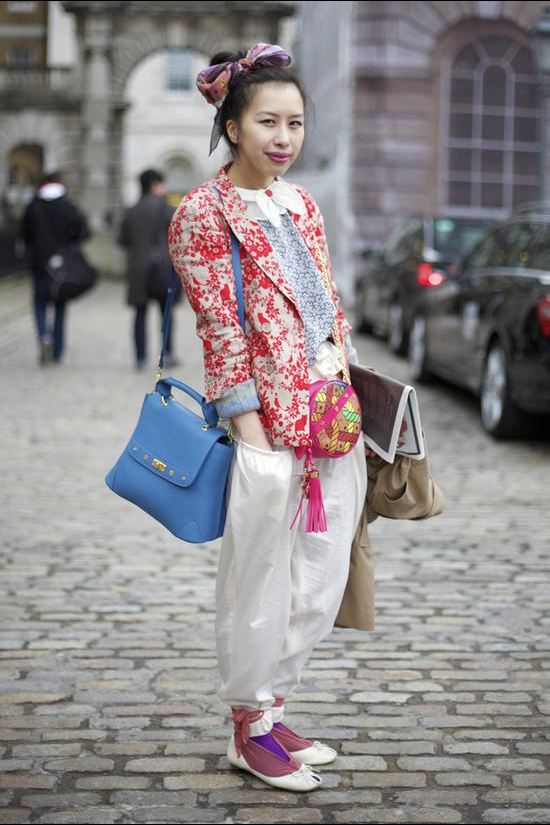

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().cpu().numpy())


In [ ]:
prediction

[{'boxes': tensor([[152.1921,  69.6550, 356.2476, 732.0933],
          [205.7708,  48.2540, 294.0830, 153.3688],
          [225.3587, 723.5970, 328.3701, 789.0154],
          [213.5622, 433.3360, 359.0516, 753.1375],
          [108.6371, 368.8351, 235.8603, 538.3029],
          [197.1312,  44.6775, 289.5479, 124.7934],
          [150.8281, 721.1117, 262.6942, 786.4257],
          [157.8848, 425.0901, 301.9769, 753.9590],
          [195.2874,  98.3473, 353.3716, 458.9961],
          [242.6123,  48.1200, 337.9256, 141.7236],
          [223.9309,  40.1526, 319.5190, 130.1428],
          [156.3573,  45.5431, 257.5262, 155.3242],
          [190.1993, 727.0421, 278.2587, 793.3748],
          [111.9920, 357.2133, 249.3746, 531.5090],
          [137.2681, 368.7297, 328.7621, 547.3041],
          [132.8477,  66.6881, 311.1440, 513.9239],
          [214.5616, 408.6268, 367.2508, 703.2500],
          [177.6160, 169.5891, 352.1383, 478.9836],
          [124.9914, 151.4728, 357.9716, 544.5100],
   

skin
hair
shoes
pants
bag
hat
purse
dress
blouse


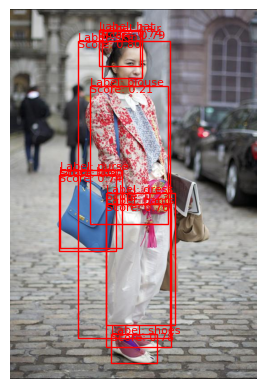

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_prediction(image, prediction):
    fig, ax = plt.subplots(1)
    ax.imshow(Image.fromarray(image.mul(255).permute(1, 2, 0).byte().cpu().numpy()))
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    labname=['null',
    'accessories',
    'bag',
    'belt',
    'blazer',
    'blouse',
    'bodysuit',
    'boots',
    'bra',
    'bracelet',
    'cape',
    'cardigan',
    'clogs',
    'coat',
    'dress',
    'earrings',
    'flats',
    'glasses',
    'gloves',
    'hair',
    'hat',
    'heels',
    'hoodie',
    'intimate',
    'jacket',
    'jeans',
    'jumper',
    'leggings',
    'loafers',
    'necklace',
    'panties',
    'pants',
    'pumps',
    'purse',
    'ring',
    'romper',
    'sandals',
    'scarf',
    'shirt',
    'shoes',
    'shorts',
    'skin',
    'skirt',
    'sneakers',
    'socks',
    'stockings',
    'suit',
    'sunglasses',
    'sweater',
    'sweatshirt',
    'swimwear',
    't-shirt',
    'tie',
    'tights',
    'top',
    'vest',
    'wallet',
    'watch',
    'wedges']
    label_data = {}
    for box, label, score in zip(boxes, labels, scores):
        if label not in label_data or score > label_data[label]['score'] and label!=0:
            label_data[label] = {'score': score, 'box': box}

    unique_labels = list(label_data.keys())
    highest_scores = [label_data[label]['score'] for label in unique_labels]
    corresponding_boxes = [label_data[label]['box'] for label in unique_labels]
    counter=0
    for label, score, box in zip(unique_labels, highest_scores, corresponding_boxes):
      if score > 0.0and counter<=8:  # Filter boxes based on score threshold
            # Get box coordinates
            xmin, ymin, xmax, ymax = box


            # Create a rectangle patch
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=1, edgecolor='r', facecolor='none')

            # Add the patch to the plot
            ax.add_patch(rect)

            # Add label and score text
            label_text = f"Label: {labname[label.item()]}"
            score_text = f"Score: {score:.2f}"
            ax.text(xmin, ymin, label_text, fontsize=8, color='r')
            ax.text(xmin, ymin + 15, score_text, fontsize=8, color='r')
            counter+=1
            print(labname[label.item()])

    plt.axis('off')
    plt.show()


plot_prediction(img.cpu(), prediction)

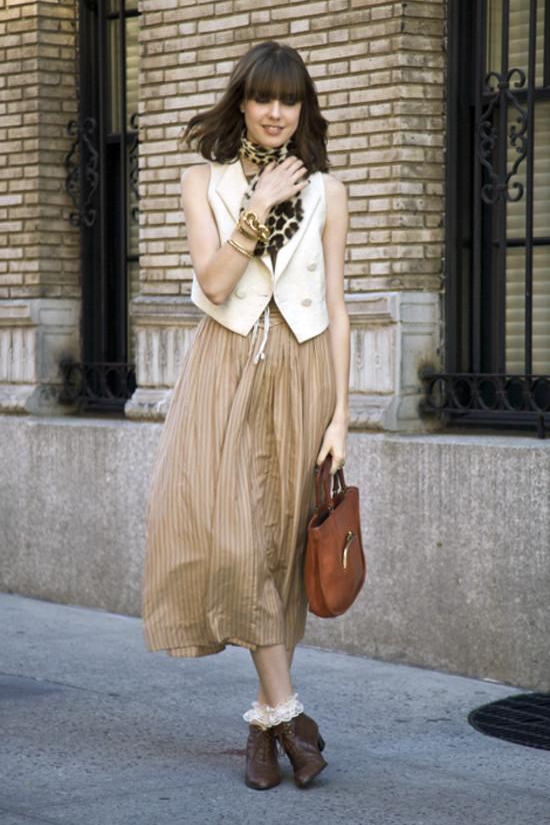

In [ ]:
img, _ = dataset_test[16]
# put the model in evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
img = img.to(device)

with torch.no_grad():
    prediction = model([img])
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().cpu().numpy())


hair
dress
skin
shoes
purse
bag
blouse
skirt
t-shirt


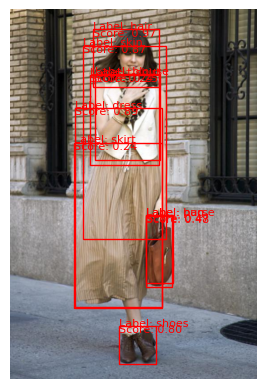

In [ ]:
plot_prediction(img.cpu(), prediction)

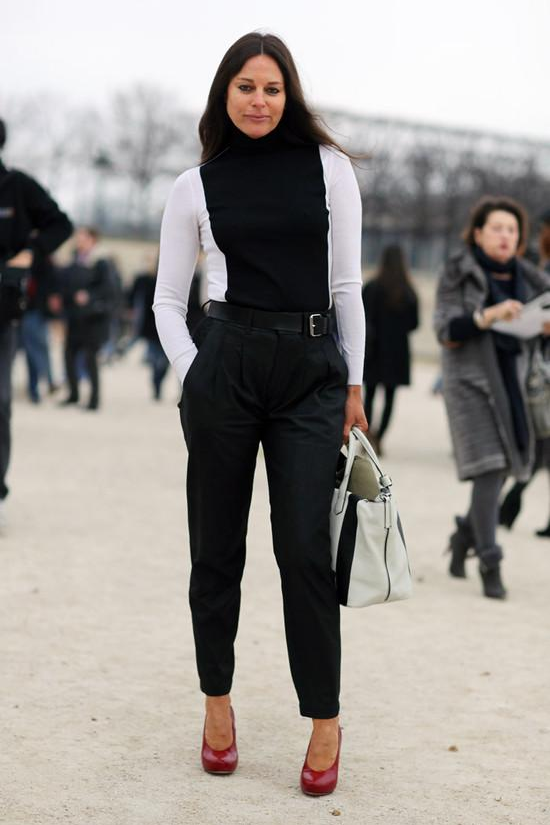

In [ ]:
img, _ = dataset_test[22]
# put the model in evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
img = img.to(device)

with torch.no_grad():
    prediction = model([img])
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().cpu().numpy())

hair
belt
skin
shoes
pants
bag
purse
blouse
jeans


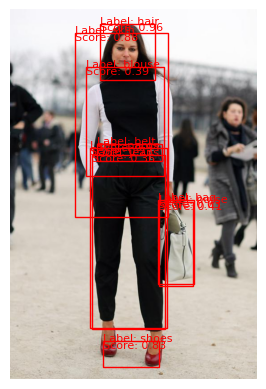

In [ ]:
plot_prediction(img.cpu(), prediction)

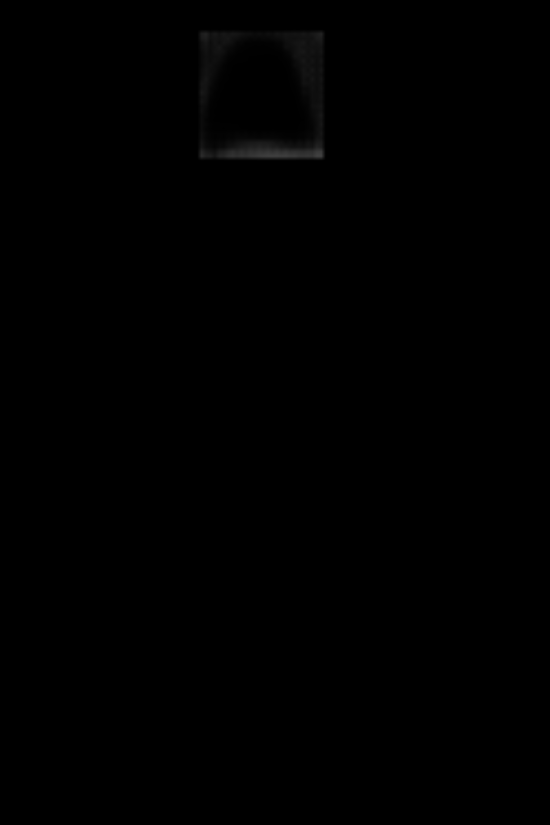

In [ ]:
import numpy as np
from PIL import Image
mask_tensor = prediction[0]["masks"].cpu().numpy()  # Convert tensor to numpy array
mask_index = 0 # Index of the mask to print

mask_array = np.squeeze(mask_tensor[mask_index])  # Get the selected mask array and remove unnecessary dimensions
mask_image = Image.fromarray((mask_array * 255).astype(np.uint8))

mask_image.save("mask_image.png")
mask_image


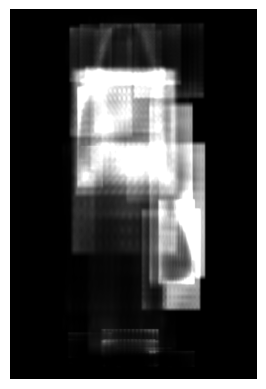

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming prediction[0]["masks"] is a tensor
mask_tensor = prediction[0]["masks"].cpu().numpy()  # Convert tensor to numpy array

# Create a blank canvas with the same dimensions as the masks
num_masks = mask_tensor.shape[0]  # Number of masks
height, width = mask_tensor.shape[-2:]  # Height and width of each mask
canvas = np.zeros((height, width))

# Overlay each mask on the canvas
for mask_index in range(num_masks):
    mask_array = np.squeeze(mask_tensor[mask_index])  # Get the mask array
    canvas += mask_array

# Normalize the values of the canvas to [0, 1]
canvas = np.clip(canvas, 0, 1)

# Display the canvas
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.show()


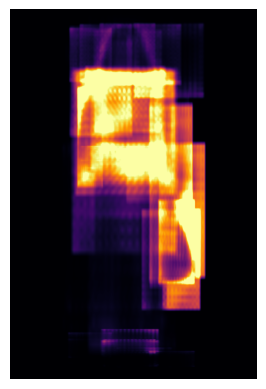

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming prediction[0]["masks"] is a tensor
mask_tensor = prediction[0]["masks"].cpu().numpy()  # Convert tensor to numpy array

# Create a blank canvas with the same dimensions as the masks
num_masks = mask_tensor.shape[0]  # Number of masks
height, width = mask_tensor.shape[-2:]  # Height and width of each mask
canvas = np.zeros((height, width))

# Overlay each mask on the canvas
for mask_index in range(num_masks):
    mask_array = np.squeeze(mask_tensor[mask_index])  # Get the mask array
    canvas += mask_array

# Normalize the values of the canvas to [0, 1]
canvas = np.clip(canvas, 0, 1)

# Convert the grayscale mask to RGB
mask_rgb = cm.inferno(canvas)  # Apply a color map (e.g., inferno) to the grayscale image

# Display the RGB mask
plt.imshow(mask_rgb)
plt.axis('off')
plt.show()
